## Imports

In [11]:
import re
import numpy as np
import pandas as pd
import nltk
import ast
from nltk.corpus import stopwords
try:
    stopwords_pt = set(stopwords.words("portuguese"))
except LookupError:
    nltk.download("stopwords")
    stopwords_pt = set(stopwords.words("portuguese"))

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Reprodutibilidade
SEED = 42

## Carregando dados do corpus

In [13]:
filmes_df = pd.read_csv('filmes_processados_csv/filmes_processados.csv')
# Converte cada string de tokens em lista de palavras
resumos = filmes_df['resumo_tokens'].apply(lambda x: x.split()).tolist()
print(resumos[:3])

[['filmes', 'começam', 'estranho', 'repente', 'mudam', 'capturando', 'atenção', 'minuto', 'minuto', 'tornando-se', 'agradável', 'surpresa', 'longa', 'título', 'brasil', 'belo', 'medianeras', 'título', 'original', 'laterais', 'prédios', 'viraram', 'propaganda', 'abrigaram', 'murais', 'pintores', 'restante', 'inserido', 'terras', 'brasileiras', 'buenos', 'aires', 'amor', 'digital', 'deve-se', 'correlação', 'texto', 'arquitetura', 'modernidade', 'crescimento', 'desordenado', 'cidade', 'caso', 'capital', 'argentina', 'reboque', 'habitantes', 'achou', 'maluco', 'apostar', 'decorrer', 'história', 'peculiaridade', 'construções', 'medianeras', 'ganhará', 'destaque', 'rir', 'atores', 'perfeita', 'sintonia', 'texto', 'javier', 'drolas', 'mural', 'bela', 'pilar', 'lópez', 'ayala', 'lope', 'história', 'mostra', 'depressão', 'começando', 'bater', 'porta', 'martin', 'mariana', 'personagens', 'sites', 'vitrinista', 'debochado', 'fobia', 'elevador', 'curte', 'guerra', 'estrelas', 'astro', 'boy', 'dive

## Treinamento do Modelo Word2Vec

In [14]:
w2v = Word2Vec(
    sentences=resumos,
    vector_size=50,   # menor dimensão evita espaço esparso
    window=3,         # contexto curto e local
    min_count=1,
    sg=0,             # CBOW é mais estável em pouco dado
    negative=10,
    sample=0.0,       # sem subsampling (não “derruba” palavras frequentes)
    epochs=400,
    workers=1,
    seed=SEED
)

vocab = list(w2v.wv.key_to_index.keys())
print(len(vocab), vocab[:20])



4504 ['filme', 'história', 'diretor', 'cinema', 'cenas', 'longa', 'vida', 'anos', 'momentos', 'filmes', 'há', 'seja', 'cena', 'personagem', 'roteiro', 'amor', 'mundo', 'trilha', 'personagens', 'produção']


## Exploração do Vocabulário

In [27]:
# 5. Palavras similares

def topn_similares(palavra, n=5):
    if palavra not in w2v.wv:
        print(f"'{palavra}' não está no vocabulário.")
        return
    for termo, score in w2v.wv.most_similar(palavra, topn=n):
        print(f"{termo:>12s}  |  {score:.3f}")

print(">> Vizinhos de 'gelo':")
topn_similares("gelo", n=5)

print("\n>> Similaridade ('desenho', 'pixar'):")
print(f"{w2v.wv.similarity('desenho','pixar'):.3f}")


>> Vizinhos de 'gelo':
           3  |  0.900
        fuja  |  0.818
     poderes  |  0.786
       isole  |  0.775
 dinossauros  |  0.740

>> Similaridade ('gelo', 'desenho'):
0.272


## Analogias

In [28]:
# 6 Analogias

def analogia(positivo, negativo, topn=5):
    try:
        for termo, score in w2v.wv.most_similar(positive=positivo, negative=negativo, topn=topn):
            print(f"{termo:>12s}  |  {score:.3f}")
    except KeyError as e:
        print("Termo fora do vocabulário:", e)

print(">> Analogia: rei - homem + mulher ≈ ?")
analogia(positivo=["rei","mulher"], negativo=["homem"], topn=5)

print("\n>> Analogia: princesa - mulher + homem ≈ ?")
analogia(positivo=["princesa","homem"], negativo=["mulher"], topn=5)

>> Analogia: rei - homem + mulher ≈ ?
Termo fora do vocabulário: "Key 'rei' not present in vocabulary"

>> Analogia: princesa - mulher + homem ≈ ?
Termo fora do vocabulário: "Key 'princesa' not present in vocabulary"


## Vizualização

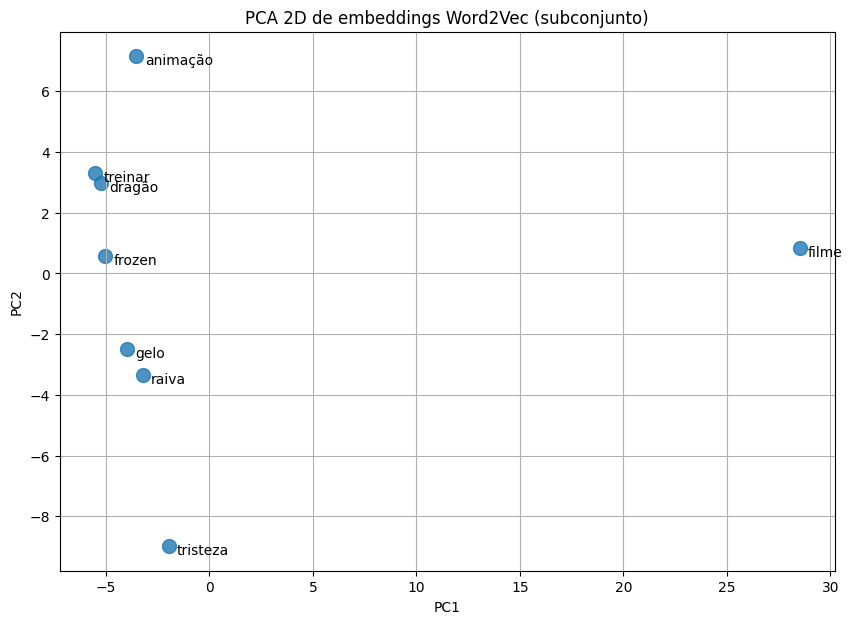

In [35]:
# 7. Visualização

palavras_plot = [
    "animação","gelo","frozen","filme","dragão","treinar", "raiva", "tristeza"
]
palavras_plot = [p for p in palavras_plot if p in w2v.wv]

X = np.vstack([w2v.wv[p] for p in palavras_plot])
pca = PCA(n_components=2, random_state=SEED)
X2 = pca.fit_transform(X)

plt.figure(figsize=(10,7))
plt.scatter(X2[:,0], X2[:,1], s=100, alpha=0.8)
for i, p in enumerate(palavras_plot):
    plt.annotate(p, (X2[i,0], X2[i,1]), xytext=(6,-6), textcoords="offset points")
plt.title("PCA 2D de embeddings Word2Vec (subconjunto)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()